In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import util
import game
import sys
#from labellines import labelLine, labelLines

In [4]:
"""
Direi che la prima cosa da fare è spliceare i dati in modo da non avere roba inutile.
quello che voglio avere è :
item id, thread id, byr id, slr id, status, offr_price
"""
data = pd.read_csv("data/anon_bo_threads.csv",sep=',',usecols=['anon_item_id', 'anon_thread_id', 'anon_byr_id', 'anon_slr_id', 'offr_type_id', 'status_id', 'offr_price', 'src_cre_date'])

In [5]:
grouped_data = data.sort_values('anon_slr_id')
#grouped_data

In [6]:
reduced_data = grouped_data[grouped_data['status_id'] != 0]
#reduced_data[:10]

In [7]:
#len(grouped_data.loc[grouped_data['anon_slr_id'] == 45])
multiplicity = grouped_data.groupby('anon_item_id').count()['anon_byr_id']
#multiplicity
#grouped_data.loc[37012993]['anon_slr_id']

In [8]:
multiplicity = multiplicity.sort_values(ascending = False)
#multiplicity.__class__.__name__
#multiplicity_reduced = multiplicity[(multiplicity >= 5) & (multiplicity <=10)]
multiplicity_reduced = multiplicity[multiplicity == 5]
#multiplicity_reduced[:10].index

In [47]:
class Game():

    def __init__(self, game):
        self._game = game.copy()
        self._buyers = np.unique(np.array(self._game['anon_byr_id']))
        #self._seller = np.array(self._game['anon_slr_id'])[0]
        self._offers = self._game.sort_values('src_cre_date', ascending = True)[['anon_byr_id','offr_type_id','status_id','offr_price', 'src_cre_date']]
        self.id_map = {}
        self._n_buyers = len(self._buyers)
        for i in range(self._n_buyers):
            self.id_map[self._buyers[i]] = i

    def get_game(self):
        return self._game.copy()

    #def get_seller(self):
    #    return self._seller.copy()

    def get_buyers(self):
        return self._buyers.copy()

    def get_offers(self):
        return self._offers.copy()

    def map_buyer(self, buyer):
        return self.id_map[buyer]

    def get_buyers_normalized(self):
        return np.array([self.map_buyer(x) for x in self._buyers])

    def get_seller_normalized(self):
        return (self._n_buyers - 1) / 2

    def sold(self):
        return len(np.array(self._game[self._game['status_id'] == 1]['anon_byr_id'])) > 0

    def get_winner(self):
        return self.id_map[np.array(self._game[self._game['status_id'] == 1]['anon_byr_id'])[0]]

    def get_winner_offer(self):
        return np.array(self._game[self._game['status_id'] == 1]['offr_price'])[0]

    def get_n_buyers(self):
        return self._n_buyers

    def make_step():
        pass

In [76]:
def create_games(index, cur, df, output):
    output[cur] = Game(game=df.loc[df['anon_item_id'] == index])

v_create_games = np.vectorize(create_games, excluded=['df', 'output'], cache=True)

In [81]:
FIRST = 5
LAST = 20
NUM_GAMES = 100
games = np.empty((LAST - FIRST,NUM_GAMES), dtype=list)
for j in range(FIRST,LAST):
    sys.stdout.write("\rProgress: " + str(round((j-FIRST) * 100 / (LAST - FIRST - 1),2)) + "%")
    multiplicity_spliced = np.array(multiplicity[multiplicity == j][:NUM_GAMES].index)
    v_create_games(index=multiplicity_spliced, cur=range(NUM_GAMES), df=grouped_data, output=games[j-FIRST])

Progress: 100.0%

In [64]:
games[0][2].get_offers()

,anon_byr_id,offr_type_id,status_id,offr_price,src_cre_date
12332506,1629698,0,7,50.0,29jan2013 19:25:43
12332560,1629698,2,7,65.0,29jan2013 19:33:26
12332736,1629698,1,1,58.0,29jan2013 19:34:31
12333159,10027533,0,7,40.0,29jan2013 19:36:50
12332843,10027533,2,8,65.0,29jan2013 19:39:12


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


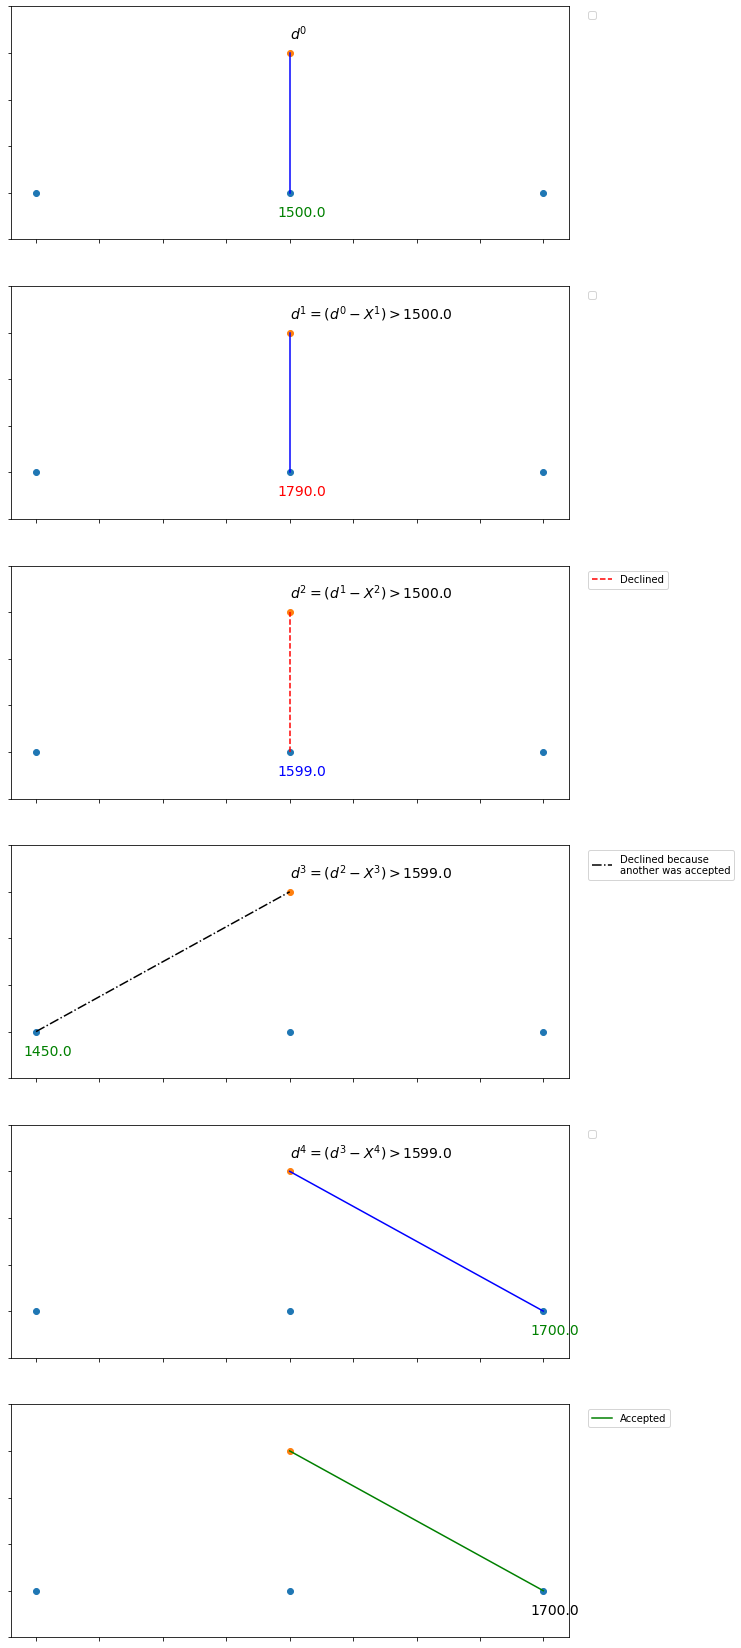

In [95]:
test_game = games[0][1]

offers = test_game.get_offers().replace(to_replace=test_game.id_map)

n_rows = len(offers) + 1 if test_game.sold() else len(offers)

fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(10,n_rows * 5))
d_seller = 0
#g initial offer, b buyer counteroffer, r seller counteroffer
colors = ['g','b','r']
i = 0
d_seller_label = '$d^0$'
for offer, ax in zip(offers.iterrows(), axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.axis('off')
    color_line = 'b'
    line_type = '-'
    label = ""
    if offer[1]['status_id'] == 6:
        color_line = 'r'
        label = "Auto declined"
    if offer[1]['status_id'] == 2:
        color_line = 'r'
        line_type = '--'
        label = "Declined"
    if (offer[1]['status_id'] == 0):
        color_line = 'black'
        label = "Offer expired"
    elif (offer[1]['status_id'] == 8):
        color_line = 'black'
        line_type = '-.'
        label = "Declined because \nanother was accepted"
    ax.plot([offer[1]['anon_byr_id'], test_game.get_seller_normalized()],[1, 4], line_type, color=color_line, label=label)
    ax.scatter(test_game.get_buyers_normalized(), [1] * test_game.get_n_buyers())
    ax.scatter(test_game.get_seller_normalized(), [4])
    #auto declined or countered
    if (offer[1]['offr_price'] > d_seller) & ((offer[1]['status_id'] == 6) | (offer[1]['status_id'] == 2) | ((offer[1]['status_id'] == 7) & (offer[1]['offr_type_id'] != 2))):
        d_seller = offer[1]['offr_price']
    ax.text(offer[1]['anon_byr_id']-0.05, 0.5, str(offer[1]['offr_price']), fontsize=14, color=colors[offer[1]['offr_type_id']])
    ax.text(test_game.get_seller_normalized(), 4.3, d_seller_label, fontsize=14)
    ax.set_ylim([0, 5])
    i = i + 1
    d_seller_label = '$d^{{{}}} = (d^{{{}}} - X^{{{}}})> {}$'.format(i,i-1,i, d_seller if d_seller != 0 else '?')
    ax.legend(bbox_to_anchor=(1.025, 1), loc='upper left')

if test_game.sold():
    axes[-1].set_xticklabels([])
    axes[-1].set_yticklabels([])
    axes[-1].scatter(test_game.get_buyers_normalized(), [1] * test_game.get_n_buyers())
    axes[-1].scatter(test_game.get_seller_normalized(), [4])
    axes[-1].plot([test_game.get_winner(), test_game.get_seller_normalized()],[1, 4], 'g', label = "Accepted")
    axes[-1].text(test_game.get_winner()-0.05, 0.5, str(test_game.get_winner_offer()), fontsize=14, color='black')
    axes[-1].set_ylim([0, 5])
    axes[-1].legend(bbox_to_anchor=(1.025, 1), loc='upper left')

#ax.set_xlabel(r'$\Delta_i$', fontsize=15)
#ax.set_ylabel(r'$\Delta_{i+1}$', fontsize=15)
#ax.set_title('Volume and percent change')

ax.grid(False)
#fig.tight_layout()
